In [1]:
# =============================================================================
# Cell 1: Setup and Imports 
# =============================================================================
import pandas as pd
import numpy as np
import re
import nltk
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_recall_curve
)
from scipy.sparse import hstack
import xgboost as xgb
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping

print("\n--- Cell 1: Setup and all imports complete ---")


--- Cell 1: Setup and all imports complete ---


In [2]:
# =============================================================================
# Cell 2: Data Loading and Preprocessing 
# =============================================================================

# Create necessary directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('results/charts', exist_ok=True)

# Load Dataset
df = pd.read_csv('loan.csv', low_memory=False)

# Define target and clean up dataset
df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['text_data'] = df['title'].fillna('') + ' ' + df['desc'].fillna('')
df['text_data'] = df['text_data'].str.strip()
df.loc[df['text_data'] == '', 'text_data'] = np.nan
df.dropna(subset=['text_data'], inplace=True)

try:
    stopwords = nltk.corpus.stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)
    
df['text_data'] = df['text_data'].apply(preprocess_text)

# Choose fields
structured_numeric_features = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'delinq_2yrs',
    'inq_last_6mths', 'pub_rec', 'collections_12_mths_ex_med'
]
structured_categorical_features = [
    'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'verification_status', 'purpose', 'addr_state'
]

text_feature = 'text_data'
target = 'is_default'

# Fill missing structured data
for col in structured_numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())
for col in structured_categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

# Thin File Criteria
print("\n--- Creating Borrower Segments for RQ2 Analysis ---")
try:
    df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
    df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['credit_history_length'] = (df['issue_d_date'] - df['earliest_cr_line_date']).dt.days / 365.25
    print("Credit history length calculated correctly.")
except Exception as e:
    print(f"Could not process date columns. Error: {e}")
    df['credit_history_length'] = np.nan

TOTAL_ACC_CUTOFF = 5
print(f"Applying filter: Open Accounts < {TOTAL_ACC_CUTOFF}")

df_cleaned = df.dropna(subset=['open_acc'])

thin_file_filter = (df_cleaned['open_acc'] < TOTAL_ACC_CUTOFF)
thin_file_df = df_cleaned[thin_file_filter].copy()
established_credit_df = df_cleaned[~thin_file_filter].copy()

print(f"Full dataset size: {len(df)}")
print(f"Thin-File segment size: {len(thin_file_df)}")
print(f"Established-Credit segment size: {len(established_credit_df)}")
print(f"Percentage of data in Thin-File segment: {(len(thin_file_df) / len(df)) * 100:.2f}%")

print("\n--- Cell 2: Data Loading and Preprocessing complete ---")




--- Creating Borrower Segments for RQ2 Analysis ---
Credit history length calculated correctly.
Applying filter: Open Accounts < 5
Full dataset size: 252964
Thin-File segment size: 12404
Established-Credit segment size: 240560
Percentage of data in Thin-File segment: 4.90%

--- Cell 2: Data Loading and Preprocessing complete ---


In [3]:
# =============================================================================
# Cell 3: Main Analysis Function
# =============================================================================

def build_mlp(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def build_lstm_hybrid(struct_shape, text_shape):
    struct_input = Input(shape=struct_shape, name='structured_input')
    struct_model = Dense(32, activation='relu')(struct_input)
    text_input = Input(shape=text_shape, name='text_input')
    text_model = LSTM(64, dropout=0.3)(text_input)
    combined = concatenate([struct_model, text_model])
    final_model = Dense(32, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(final_model)
    model = Model(inputs=[struct_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def run_full_analysis(data, segment_name):
    print(f"\n{'='*50}")
    print(f"STARTING ANALYSIS FOR: {segment_name.upper()} SEGMENT")
    print(f"{'='*50}")

    X = data[structured_numeric_features + structured_categorical_features + [text_feature]]
    y = data[target]
    X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Training set size: {len(X_train_full)}, Final test set size: {len(X_test_final)}")

    structured_numeric_features_local = X_train_full.select_dtypes(include=np.number).columns.tolist()
    structured_categorical_features_local = X_train_full.select_dtypes(include='object').drop('text_data', axis=1).columns.tolist()
    preprocessor_structured = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), structured_numeric_features_local),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), structured_categorical_features_local)
        ],
        remainder='drop'
    )
    bert_model = SentenceTransformer('all-MiniLM-L6-v2')
    X_train_full_bert_text = bert_model.encode(X_train_full['text_data'].tolist(), show_progress_bar=True, device='cpu')

    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    all_cv_results = {}
    models_to_train = {
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=1),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'MLP': 'custom_mlp',
        'LSTM_Hybrid': 'custom_lstm',
        'TabNet': TabNetClassifier(optimizer_params=dict(lr=2e-2), verbose=0)
    }

    warnings.filterwarnings('ignore', message='Best weights from best epoch are automatically used!')
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"\n--- FOLD {fold+1}/{N_SPLITS} for {segment_name} ---")
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
        X_train_struct_processed = preprocessor_structured.fit_transform(X_train)
        X_val_struct_processed = preprocessor_structured.transform(X_val)
        
        preprocessor_tfidf_fold = ColumnTransformer(transformers=[('num', StandardScaler(), structured_numeric_features_local),('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), structured_categorical_features_local),('tfidf', TfidfVectorizer(max_features=1000), 'text_data')], remainder='drop')
        X_train_tfidf = preprocessor_tfidf_fold.fit_transform(X_train)
        X_val_tfidf = preprocessor_tfidf_fold.transform(X_val)

        def document_vector(doc, model):
            doc_words = [word for word in doc.split() if word in model.wv.index_to_key]
            if not doc_words: return np.zeros(model.vector_size)
            return np.mean(model.wv[doc_words], axis=0)

        tokenized_text_train = [text.split() for text in X_train['text_data']]
        w2v_model = Word2Vec(sentences=tokenized_text_train, vector_size=100, window=5, min_count=2, workers=4)
        X_train_w2v_text = np.array([document_vector(text, w2v_model) for text in X_train['text_data']])
        X_val_w2v_text = np.array([document_vector(text, w2v_model) for text in X_val['text_data']])
        X_train_w2v = np.hstack([X_train_struct_processed, X_train_w2v_text])
        X_val_w2v = np.hstack([X_val_struct_processed, X_val_w2v_text])
        
        X_train_bert_text = X_train_full_bert_text[train_idx]
        X_val_bert_text = X_train_full_bert_text[val_idx]
        X_train_bert = np.hstack([X_train_struct_processed, X_train_bert_text])
        X_val_bert = np.hstack([X_val_struct_processed, X_val_bert_text])

        feature_sets = {
            'structured_only': (X_train_struct_processed, X_val_struct_processed),
            'tfidf': (X_train_tfidf, X_val_tfidf), 
            'w2v': (X_train_w2v, X_val_w2v), 
            'bert': (X_train_bert, X_val_bert)
        }
        
        for model_name, model_obj in models_to_train.items():
            for fs_name, (X_train_fs, X_val_fs) in feature_sets.items():
                if model_name == 'LSTM_Hybrid' and fs_name != 'w2v': continue
                if fs_name == 'structured_only' and model_name == 'LSTM_Hybrid': continue
                
                result_key = f"{model_name}_{fs_name}" if model_name != 'LSTM_Hybrid' else "LSTM_Hybrid"
                if fold == 0: all_cv_results[result_key] = []
                
                print(f"  - Training {result_key}...")

                if model_name in ['LogisticRegression', 'XGBoost']:
                    model_obj.fit(X_train_fs, y_train)
                    y_pred_proba = model_obj.predict_proba(X_val_fs)[:, 1]
                elif model_name == 'MLP':
                    mlp_model = build_mlp((X_train_fs.shape[1],))
                    mlp_model.fit(X_train_fs, y_train, epochs=30, batch_size=256, verbose=0,
                                  validation_data=(X_val_fs, y_val),
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
                    y_pred_proba = mlp_model.predict(X_val_fs, verbose=0).flatten()
                elif model_name == 'LSTM_Hybrid':
                    X_train_text_reshaped = X_train_fs[:, X_train_struct_processed.shape[1]:].reshape(X_train_fs.shape[0], 1, 100)
                    X_val_text_reshaped = X_val_fs[:, X_val_struct_processed.shape[1]:].reshape(X_val_fs.shape[0], 1, 100)
                    lstm_model = build_lstm_hybrid(X_train_struct_processed.shape[1:], X_train_text_reshaped.shape[1:])
                    lstm_model.fit(
                        [X_train_struct_processed, X_train_text_reshaped], y_train,
                        validation_data=([X_val_struct_processed, X_val_text_reshaped], y_val),
                        epochs=30, batch_size=256, verbose=0,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
                    )
                    y_pred_proba = lstm_model.predict([X_val_struct_processed, X_val_text_reshaped], verbose=0).flatten()
                elif model_name == 'TabNet':
                    X_train_dense = X_train_fs.toarray() if hasattr(X_train_fs, 'toarray') else X_train_fs
                    X_val_dense = X_val_fs.toarray() if hasattr(X_val_fs, 'toarray') else X_val_fs
                    model_obj.fit(
                        X_train_dense, y_train.values,
                        eval_set=[(X_val_dense, y_val.values)],
                        patience=10, max_epochs=100,
                        eval_metric=['auc']
                    )
                    y_pred_proba = model_obj.predict_proba(X_val_dense)[:, 1]

                all_cv_results[result_key].append({'y_true': y_val, 'y_pred_proba': y_pred_proba})

    OPTIMAL_THRESHOLD = 0.2 
    summary_data = []
    for model_name, fold_results in all_cv_results.items():
        fold_f1s, fold_auprcs, fold_precisions, fold_recalls = [], [], [], []
        
        if not fold_results: continue
        for result in fold_results:
            y_true = result['y_true']
            y_pred_proba = result['y_pred_proba']
            y_pred_class = (y_pred_proba >= OPTIMAL_THRESHOLD).astype(int)
            
            fold_f1s.append(f1_score(y_true, y_pred_class, zero_division=0))
            fold_auprcs.append(average_precision_score(y_true, y_pred_proba))
            fold_precisions.append(precision_score(y_true, y_pred_class, zero_division=0))
            fold_recalls.append(recall_score(y_true, y_pred_class, zero_division=0))
            
        summary_data.append({
            'Model': model_name,
            'Mean F1-Score': np.mean(fold_f1s),
            'Mean AUPRC': np.mean(fold_auprcs),
            'Mean Precision': np.mean(fold_precisions),
            'Mean Recall': np.mean(fold_recalls)
        })
    
    cv_summary_df = pd.DataFrame(summary_data).set_index('Model').sort_values(by='Mean F1-Score', ascending=False)
    print(f"\n--- CV PERFORMANCE SUMMARY for {segment_name.upper()} ---")
    print(cv_summary_df)
    
    return cv_summary_df, all_cv_results, X_train_full, y_train_full, X_test_final, y_test_final

print("\n--- Main Analysis Function complete ---")


--- Main Analysis Function complete ---


In [4]:
# =============================================================================
# Cell 4: Model Training
# =============================================================================

print("--- Starting Analysis for Thin-File Segment ---")
cv_summary_df_thin_file, all_cv_results_thin_file, X_train_thin, y_train_thin, X_test_thin, y_test_thin = run_full_analysis(thin_file_df, 'Thin-File')

print("\n--- Starting Analysis for Established-Credit Segment ---")
cv_summary_df_established, all_cv_results_established, X_train_est, y_train_est, X_test_est, y_test_est = run_full_analysis(established_credit_df, 'Established-Credit')

print("\n--- Cell 4: Model Training complete ---")

--- Starting Analysis for Thin-File Segment ---

STARTING ANALYSIS FOR: THIN-FILE SEGMENT
Training set size: 9923, Final test set size: 2481


Batches:   0%|          | 0/311 [00:00<?, ?it/s]


--- FOLD 1/5 for Thin-File ---
  - Training LogisticRegression_structured_only...
  - Training LogisticRegression_tfidf...
  - Training LogisticRegression_w2v...
  - Training LogisticRegression_bert...
  - Training XGBoost_structured_only...
  - Training XGBoost_tfidf...
  - Training XGBoost_w2v...
  - Training XGBoost_bert...
  - Training MLP_structured_only...
  - Training MLP_tfidf...
  - Training MLP_w2v...
  - Training MLP_bert...
  - Training LSTM_Hybrid...
  - Training TabNet_structured_only...

Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_auc = 0.66143
  - Training TabNet_tfidf...

Early stopping occurred at epoch 52 with best_epoch = 42 and best_val_0_auc = 0.65276
  - Training TabNet_w2v...

Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_auc = 0.6674
  - Training TabNet_bert...

Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_0_auc = 0.65168

--- FOLD 2/5 for Thin-File ---
  - Training LogisticRegressio

Batches:   0%|          | 0/6014 [00:00<?, ?it/s]


--- FOLD 1/5 for Established-Credit ---
  - Training LogisticRegression_structured_only...
  - Training LogisticRegression_tfidf...
  - Training LogisticRegression_w2v...
  - Training LogisticRegression_bert...
  - Training XGBoost_structured_only...
  - Training XGBoost_tfidf...
  - Training XGBoost_w2v...
  - Training XGBoost_bert...
  - Training MLP_structured_only...
  - Training MLP_tfidf...
  - Training MLP_w2v...
  - Training MLP_bert...
  - Training LSTM_Hybrid...
  - Training TabNet_structured_only...

Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_auc = 0.70842
  - Training TabNet_tfidf...

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_auc = 0.70552
  - Training TabNet_w2v...

Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_auc = 0.71139
  - Training TabNet_bert...

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_auc = 0.70938

--- FOLD 2/5 for Established-Credit ---
  - Traini


--- Figure 18: F1-Score and AUPRC Uplift from Unstructured Data for Thin-File ---


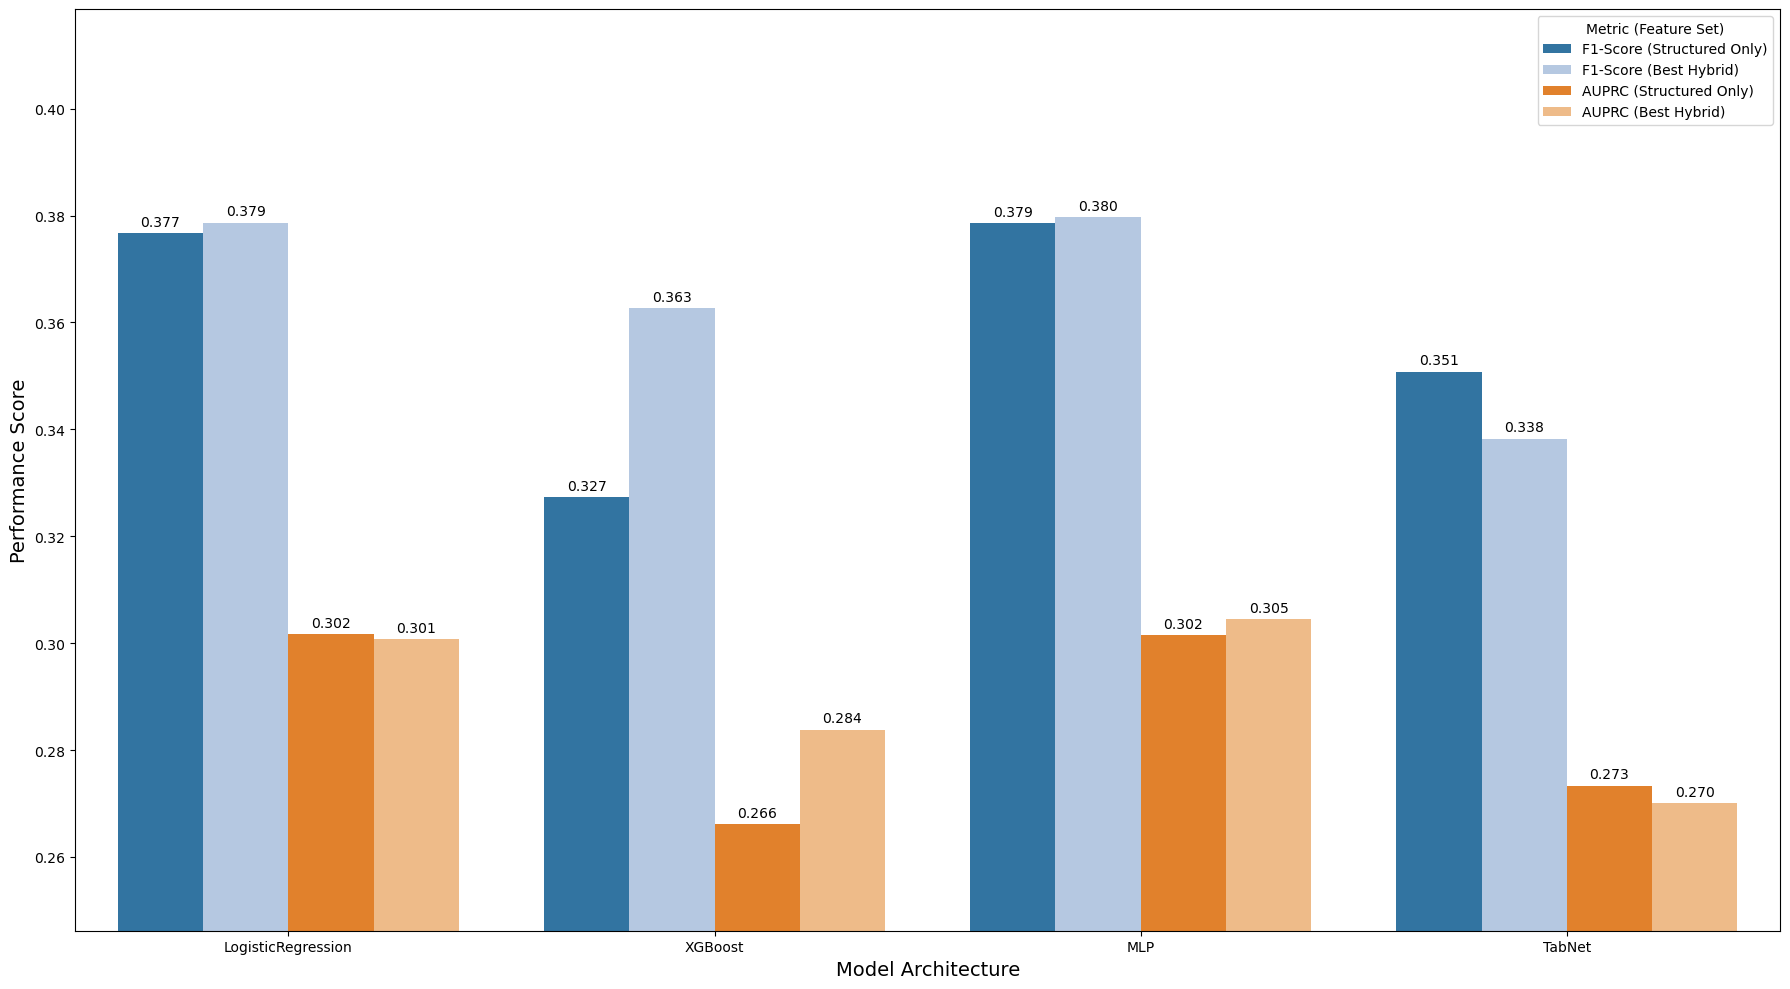


--- Figure 19: F1-Score and AUPRC Uplift from Unstructured Data for Established-Credit ---


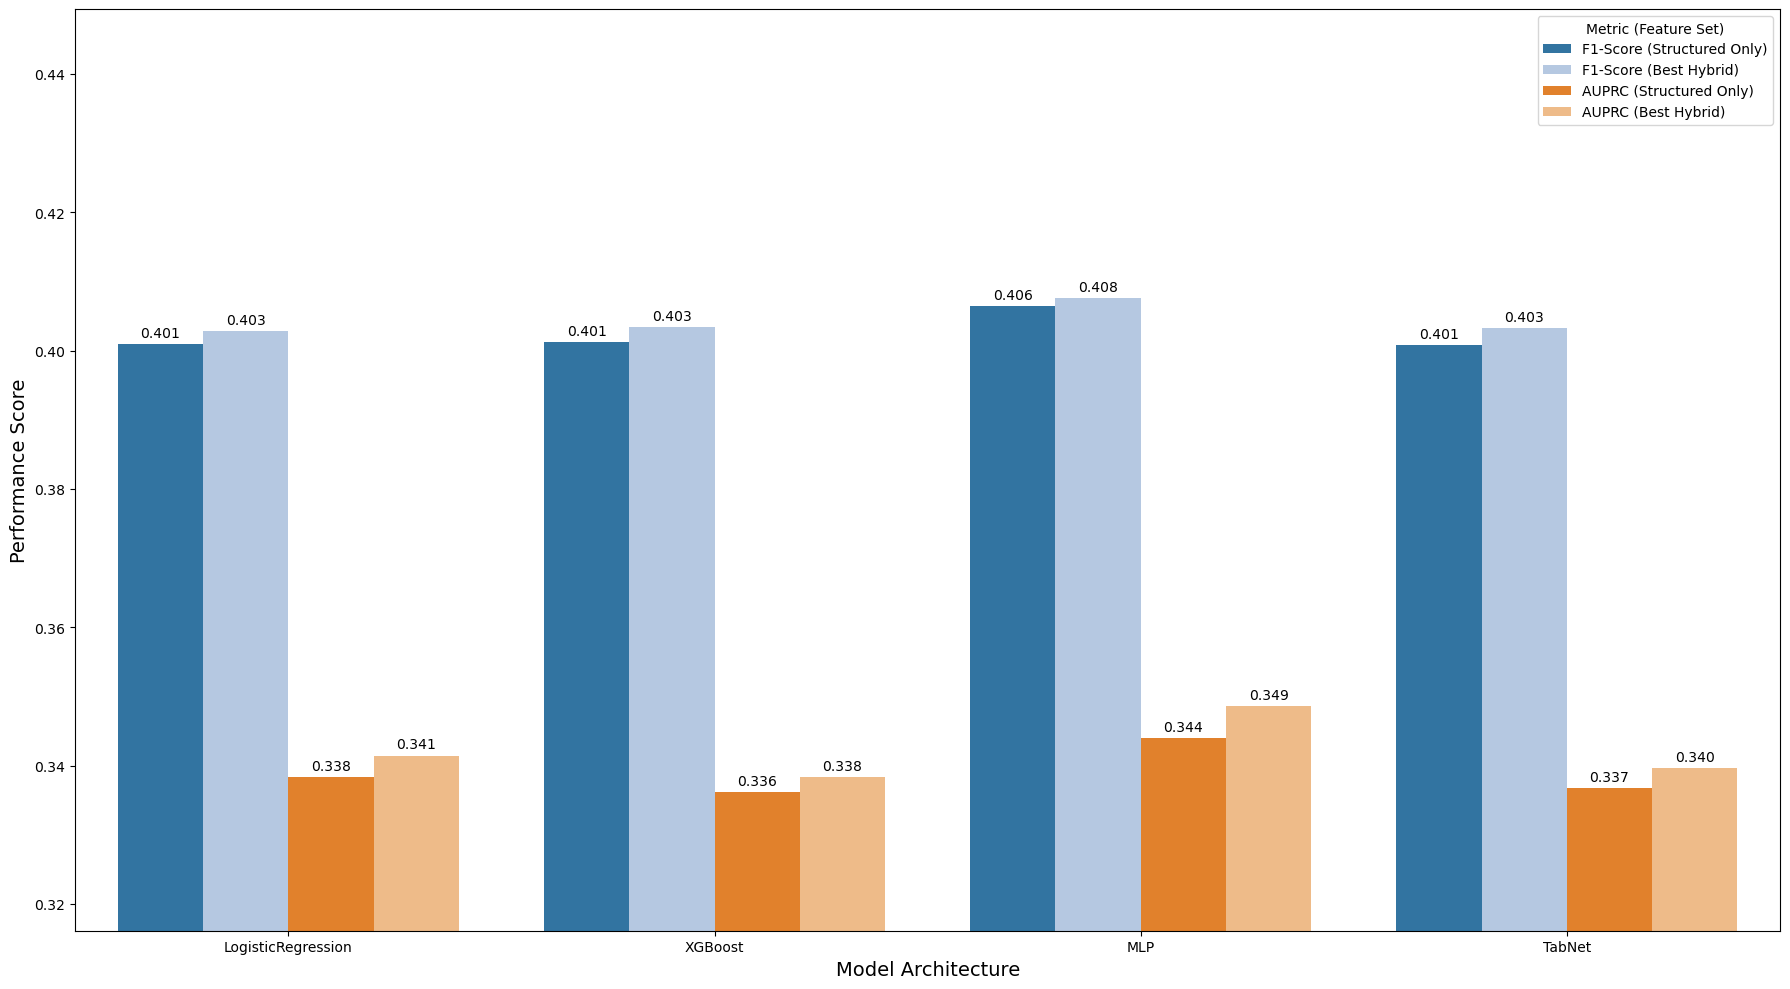


--- Figure 20: Percentage Uplift in Performance ---


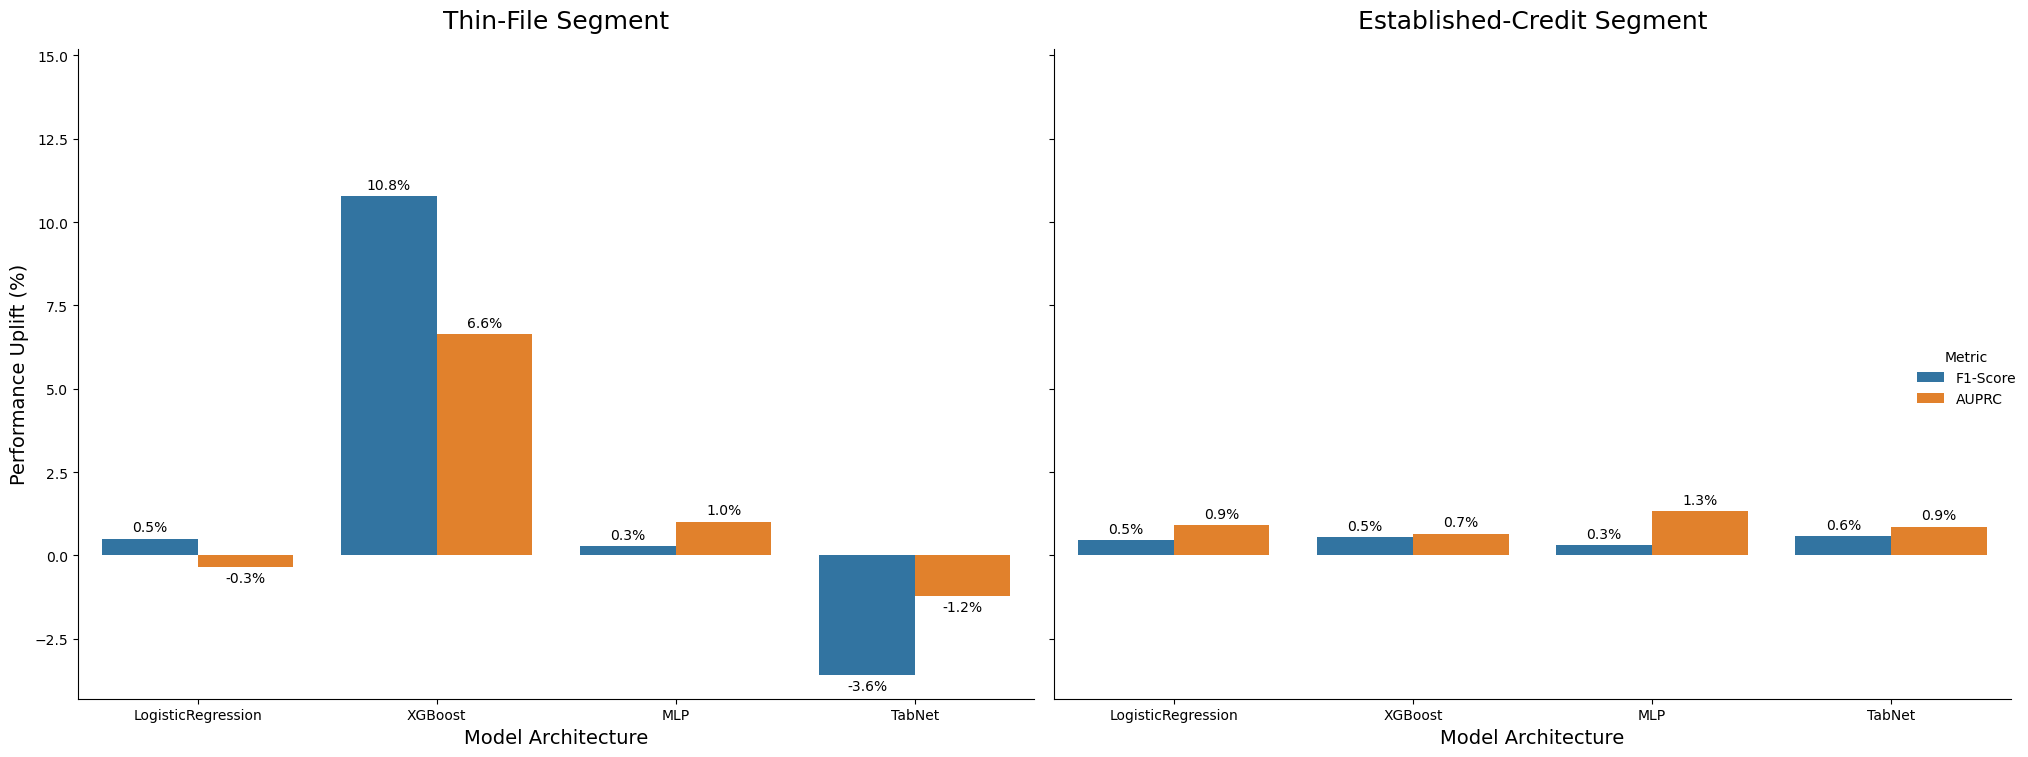


--- Figure 21: Performance Trajectory for Thin-File ---


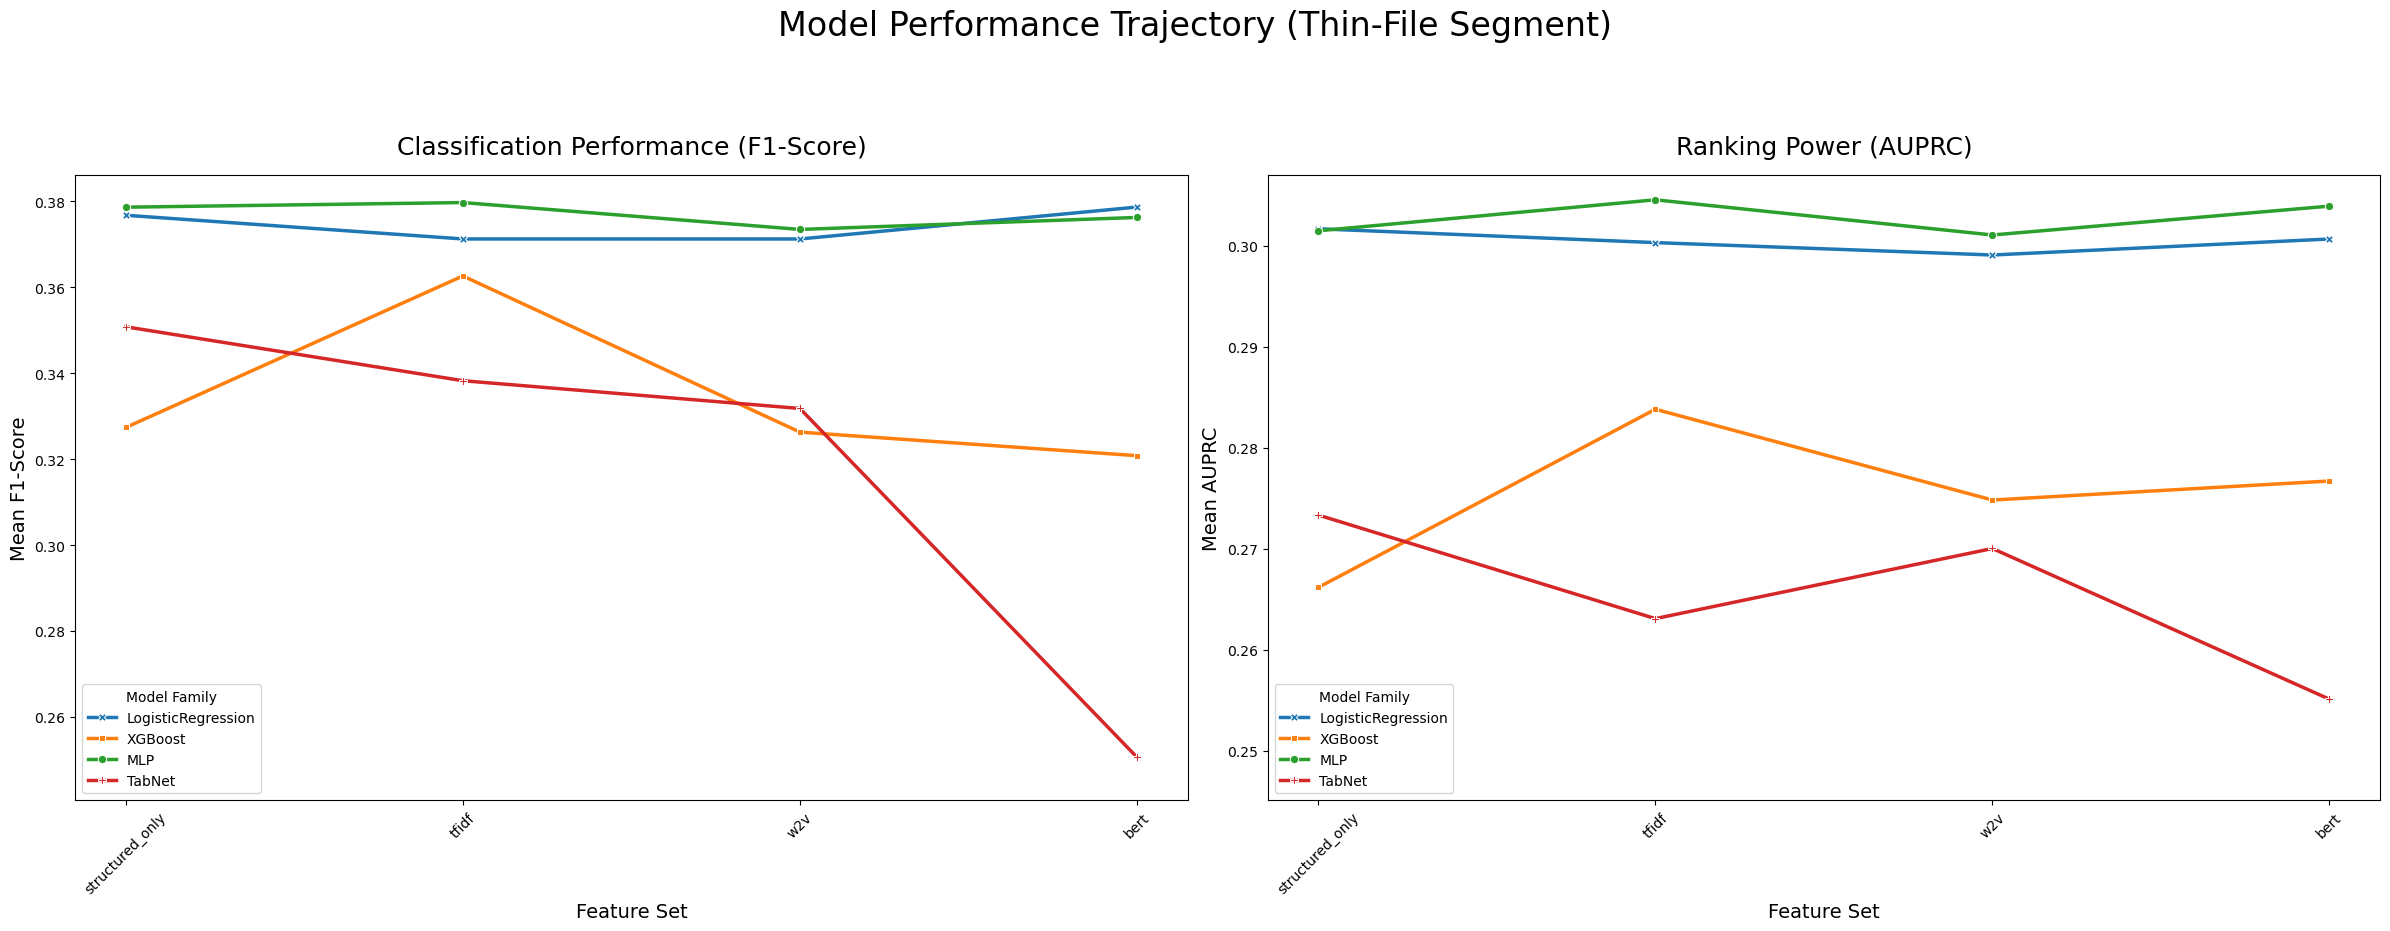


--- Figure 22: Performance Trajectory for Established-Credit ---


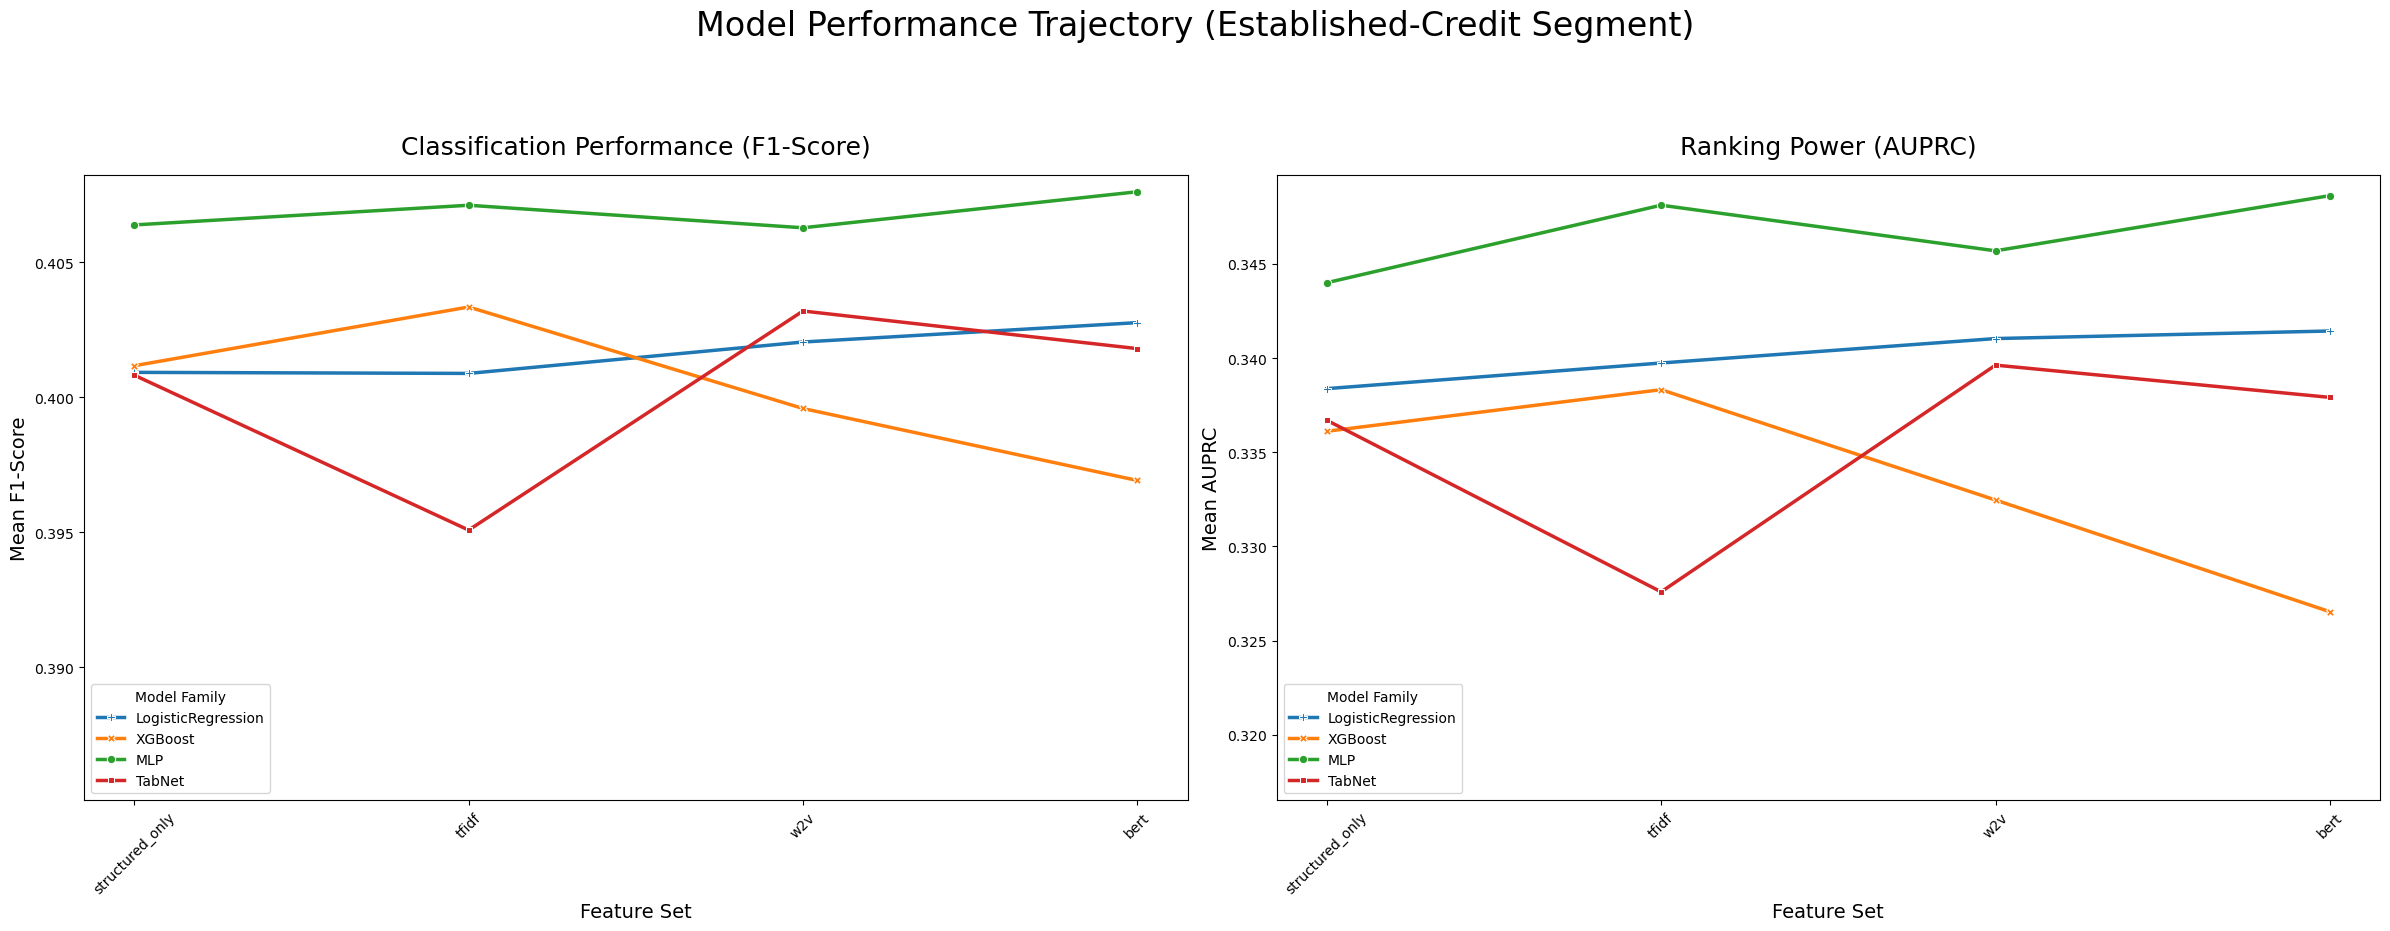


--- Figure 23: F1-Score Sensitivity Analysis for Thin-File ---


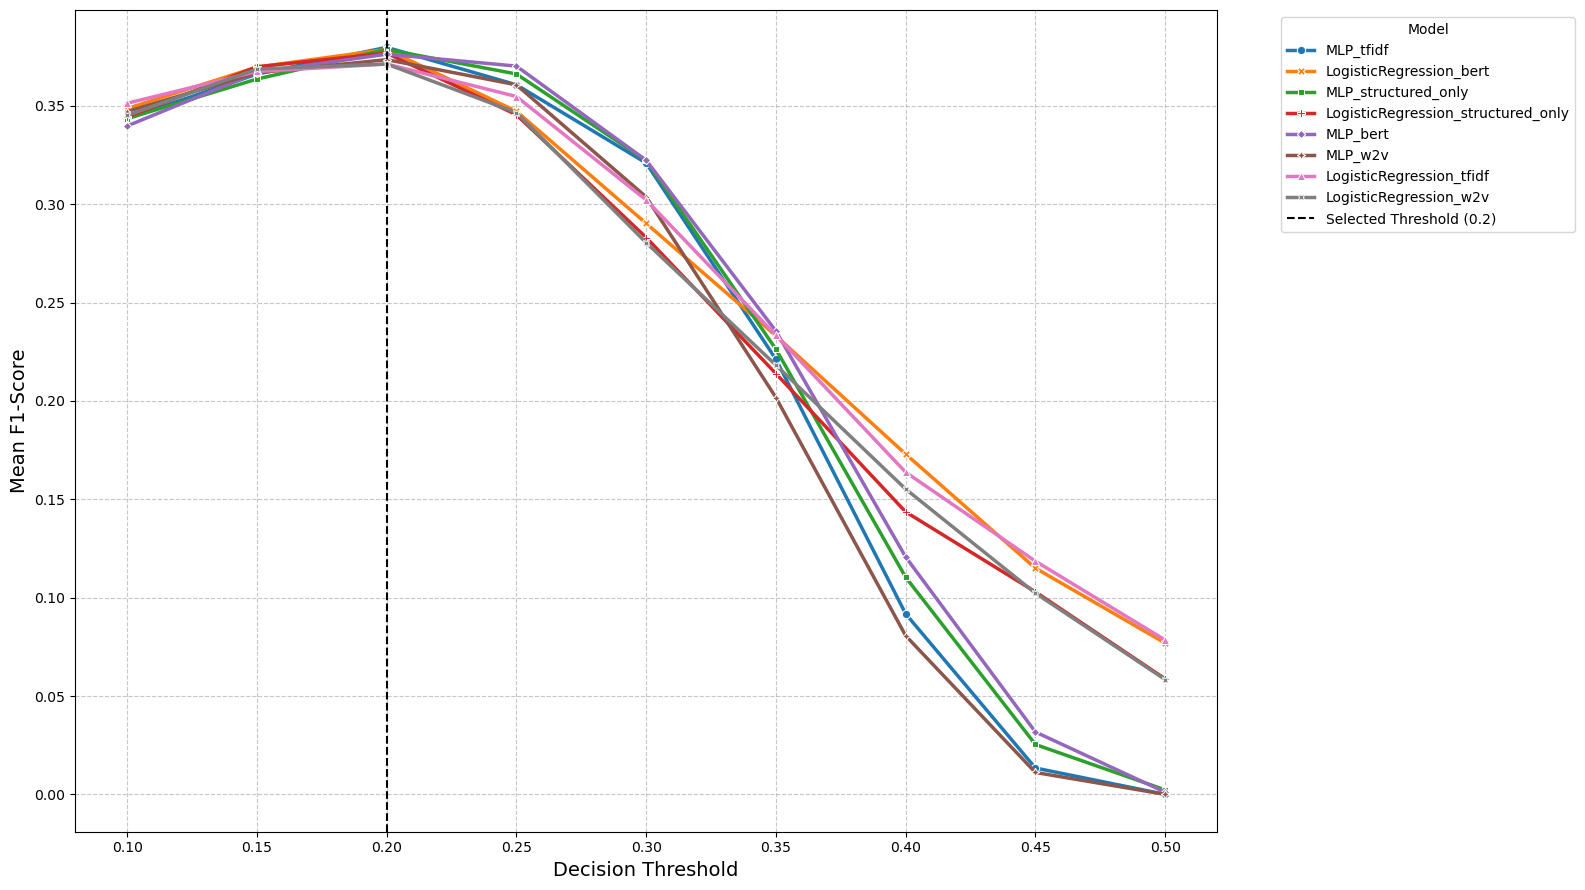


--- Figure 24: F1-Score Sensitivity Analysis for Established-Credit ---


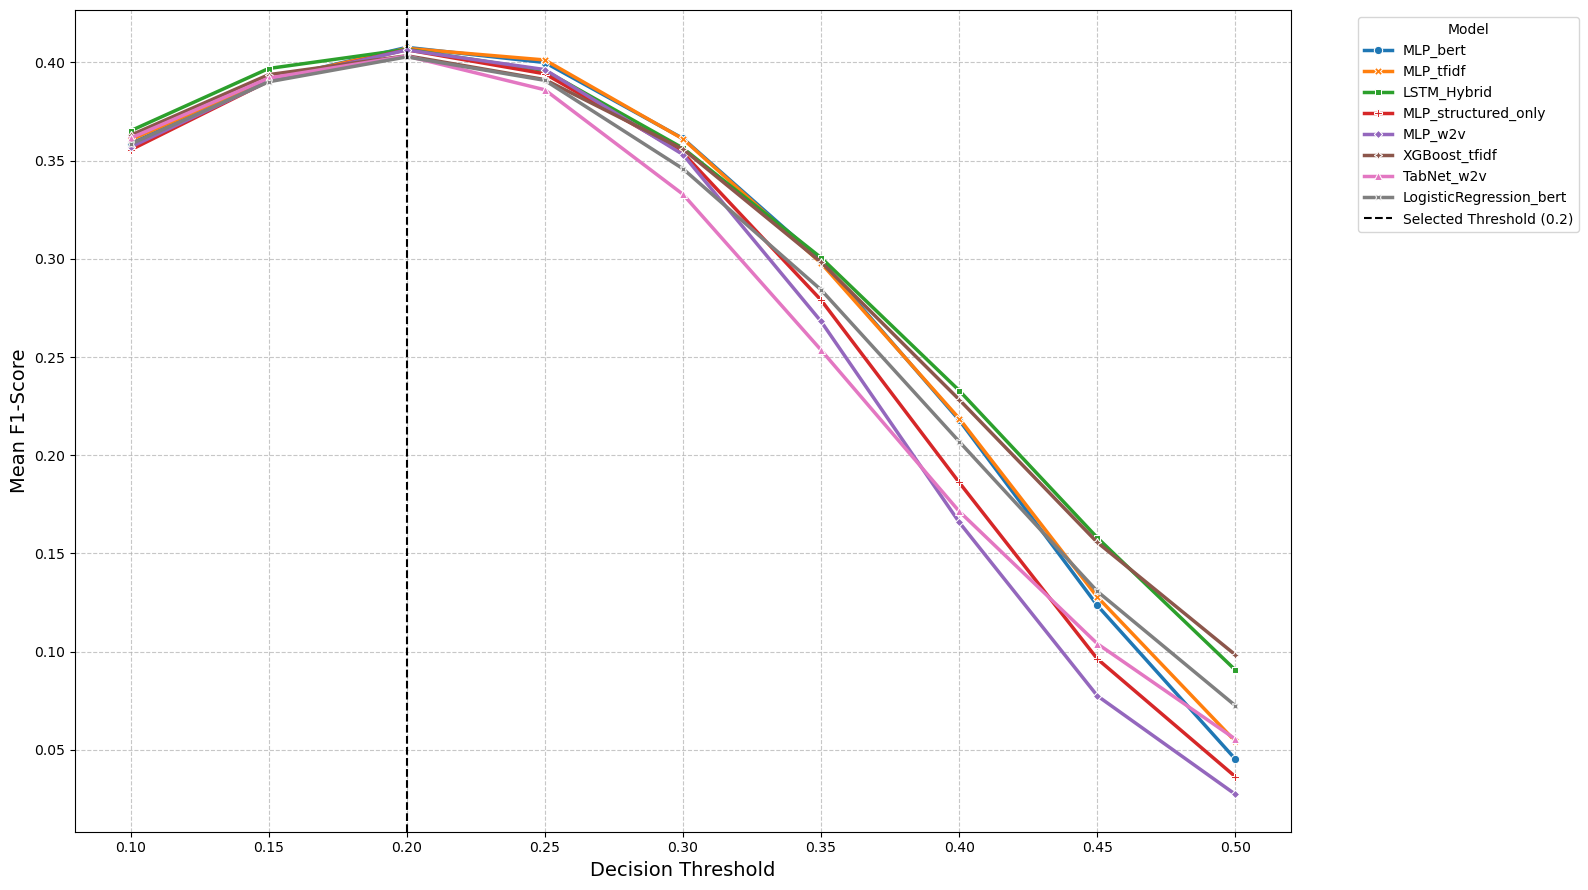


--- Cell 5: Graphs for Analysis complete ---


In [5]:
# =============================================================================
# Cell 5: Graphs for Analysis
# =============================================================================

def calculate_uplift(summary_df, model_family, metric_name):
    try:
        baseline_score = summary_df.loc[f'{model_family}_structured_only'][metric_name]
        hybrid_models = summary_df[summary_df.index.str.startswith(f'{model_family}_') & ~summary_df.index.str.contains('structured_only')]
        if hybrid_models.empty or baseline_score == 0:
            return 0.0
        best_hybrid_score = hybrid_models[metric_name].max()
        uplift = ((best_hybrid_score - baseline_score) / baseline_score) * 100
        return uplift
    except KeyError:
        return 0.0

def prepare_plot_data(summary_df):
    model_families = ['LogisticRegression', 'XGBoost', 'MLP', 'TabNet']
    plot_data = []
    for family in model_families:
        try:
            baseline_f1 = summary_df.loc[f'{family}_structured_only']['Mean F1-Score']
            baseline_auprc = summary_df.loc[f'{family}_structured_only']['Mean AUPRC']
            
            hybrid_models = summary_df[summary_df.index.str.startswith(f'{family}_') & ~summary_df.index.str.contains('structured_only')]
            if not hybrid_models.empty:
                best_hybrid_f1 = hybrid_models['Mean F1-Score'].max()
                best_hybrid_auprc = hybrid_models['Mean AUPRC'].max()
                
                plot_data.append({'Model Family': family, 'Metric': 'F1-Score (Structured Only)', 'Score': baseline_f1})
                plot_data.append({'Model Family': family, 'Metric': 'F1-Score (Best Hybrid)', 'Score': best_hybrid_f1})
                plot_data.append({'Model Family': family, 'Metric': 'AUPRC (Structured Only)', 'Score': baseline_auprc})
                plot_data.append({'Model Family': family, 'Metric': 'AUPRC (Best Hybrid)', 'Score': best_hybrid_auprc})
        except KeyError:
            print(f"Warning: Could not find all models for family {family} in the provided summary.")
    return pd.DataFrame(plot_data)

thin_file_plot_df = prepare_plot_data(cv_summary_df_thin_file)
established_credit_plot_df = prepare_plot_data(cv_summary_df_established)
custom_palette = {'F1-Score (Structured Only)': '#1f77b4', 'F1-Score (Best Hybrid)': '#aec7e8', 'AUPRC (Structured Only)': '#ff7f0e', 'AUPRC (Best Hybrid)': '#ffbb78'}

# Figure 16: F1-Score and AUPRC Uplift from Unstructured Data for Thin-File
print("\n--- Figure 18: F1-Score and AUPRC Uplift from Unstructured Data for Thin-File ---")
plt.figure(figsize=(18, 10))
ax1 = sns.barplot(data=thin_file_plot_df, x='Model Family', y='Score', hue='Metric', palette=custom_palette, hue_order=['F1-Score (Structured Only)', 'F1-Score (Best Hybrid)', 'AUPRC (Structured Only)', 'AUPRC (Best Hybrid)'])

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', padding=3)

plt.xlabel('Model Architecture', fontsize=14)
plt.ylabel('Performance Score', fontsize=14)
min_score_tf = thin_file_plot_df['Score'].min() if not thin_file_plot_df.empty else 0
plt.ylim(bottom=max(0, min_score_tf - 0.02), top=plt.gca().get_ylim()[1] * 1.05)
plt.legend(title='Metric (Feature Set)')
plt.tight_layout()
plt.savefig('results/charts/Figure16.png')
plt.show()



# Figure 17: F1-Score and AUPRC Uplift from Unstructured Data for Established-Credit
print("\n--- Figure 17: F1-Score and AUPRC Uplift from Unstructured Data for Established-Credit ---")
plt.figure(figsize=(18, 10))
ax2 = sns.barplot(data=established_credit_plot_df, x='Model Family', y='Score', hue='Metric', palette=custom_palette, hue_order=['F1-Score (Structured Only)', 'F1-Score (Best Hybrid)', 'AUPRC (Structured Only)', 'AUPRC (Best Hybrid)'])

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', padding=3)

plt.xlabel('Model Architecture', fontsize=14)
plt.ylabel('Performance Score', fontsize=14)
min_score_est = established_credit_plot_df['Score'].min() if not established_credit_plot_df.empty else 0
plt.ylim(bottom=max(0, min_score_est - 0.02), top=plt.gca().get_ylim()[1] * 1.05)
plt.legend(title='Metric (Feature Set)')
plt.tight_layout()
plt.savefig('results/charts/Figure17.png')
plt.show()

# Figure 18: Percentage Uplift in Performance
print("\n--- Figure 18: Percentage Uplift in Performance ---")
model_families = ['LogisticRegression', 'XGBoost', 'MLP', 'TabNet']
uplift_results = []
for family in model_families:
    thin_file_f1_uplift = calculate_uplift(cv_summary_df_thin_file, family, 'Mean F1-Score')
    thin_file_auprc_uplift = calculate_uplift(cv_summary_df_thin_file, family, 'Mean AUPRC')
    uplift_results.append({'Segment': 'Thin-File', 'Model Family': family, 'Metric': 'F1-Score', 'Uplift (%)': thin_file_f1_uplift})
    uplift_results.append({'Segment': 'Thin-File', 'Model Family': family, 'Metric': 'AUPRC', 'Uplift (%)': thin_file_auprc_uplift})

    established_f1_uplift = calculate_uplift(cv_summary_df_established, family, 'Mean F1-Score')
    established_auprc_uplift = calculate_uplift(cv_summary_df_established, family, 'Mean AUPRC')
    uplift_results.append({'Segment': 'Established-Credit', 'Model Family': family, 'Metric': 'F1-Score', 'Uplift (%)': established_f1_uplift})
    uplift_results.append({'Segment': 'Established-Credit', 'Model Family': family, 'Metric': 'AUPRC', 'Uplift (%)': established_auprc_uplift})

uplift_comparison_df = pd.DataFrame(uplift_results)
g = sns.catplot(data=uplift_comparison_df, x='Model Family', y='Uplift (%)', hue='Metric', col='Segment', kind='bar', palette={"F1-Score": "#1f77b4", "AUPRC": "#ff7f0e"}, height=8, aspect=1.2)

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

axes = g.axes.flatten()
axes[0].set_title('Thin-File Segment', fontsize=18, pad=15)
axes[0].set_ylabel('Performance Uplift (%)', fontsize=14)
axes[0].set_xlabel('Model Architecture', fontsize=14)
axes[1].set_title('Established-Credit Segment', fontsize=18, pad=15)
axes[1].set_ylabel('')
axes[1].set_xlabel('Model Architecture', fontsize=14)

for ax in g.axes.flat:
    ax.set_ylim(top=ax.get_ylim()[1] * 1.15)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('results/charts/Figure18.png')
plt.show()



def plot_performance_trajectory(summary_df, segment_name):
    plot_data = summary_df[['Mean F1-Score', 'Mean AUPRC']].copy()
    plot_data['Model Family'] = plot_data.index.str.split('_').str[0]
    plot_data['Feature Set'] = plot_data.index.str.split('_').str[1:].str.join('_')
    plot_data = plot_data[plot_data['Model Family'] != 'LSTM']
    melted_plot_data = plot_data.melt(
        id_vars=['Model Family', 'Feature Set'],
        var_name='Metric',
        value_name='Score'
    )
    feature_order = ['structured_only', 'tfidf', 'w2v', 'bert']
    melted_plot_data['Feature Set'] = pd.Categorical(
        melted_plot_data['Feature Set'], categories=feature_order, ordered=True
    )
    fig, axes = plt.subplots(1, 2, figsize=(24, 9), sharey=False)
    fig.suptitle(f'Model Performance Trajectory ({segment_name} Segment)', fontsize=24, y=1.03)

    palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    hue_order = ['LogisticRegression', 'XGBoost', 'MLP', 'TabNet']

    f1_data = melted_plot_data[melted_plot_data['Metric'] == 'Mean F1-Score']
    sns.lineplot(
        data=f1_data, x='Feature Set', y='Score', hue='Model Family', style='Model Family',
        markers=True, dashes=False, lw=2.5, palette=palette, ax=axes[0], hue_order=hue_order
    )
    axes[0].set_title('Classification Performance (F1-Score)', fontsize=18, pad=15)
    axes[0].set_ylabel('Mean F1-Score', fontsize=14)
    axes[0].set_xlabel('Feature Set', fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)
    min_f1 = f1_data['Score'].min() if not f1_data.empty else 0
    axes[0].set_ylim(bottom=max(0, min_f1 - 0.01))
    axes[0].legend(title='Model Family', loc='lower left')

    auprc_data = melted_plot_data[melted_plot_data['Metric'] == 'Mean AUPRC']
    sns.lineplot(
        data=auprc_data, x='Feature Set', y='Score', hue='Model Family', style='Model Family',
        markers=True, dashes=False, lw=2.5, palette=palette, ax=axes[1], hue_order=hue_order
    )
    axes[1].set_title('Ranking Power (AUPRC)', fontsize=18, pad=15)
    axes[1].set_ylabel('Mean AUPRC', fontsize=14)
    axes[1].set_xlabel('Feature Set', fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)
    min_auprc = auprc_data['Score'].min() if not auprc_data.empty else 0
    axes[1].set_ylim(bottom=max(0, min_auprc - 0.01))
    
    axes[1].legend(title='Model Family', loc='lower left')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'results/charts/performance_trajectory_{segment_name}.png')
    plt.show()


# Figure 19: Performance Trajectory for Thin-File
print("\n--- Figure 19: Performance Trajectory for Thin-File ---")
plot_performance_trajectory(cv_summary_df_thin_file, 'Thin-File')

# Figure 20: Performance Trajectory for Established-Credit
print("\n--- Figure 20: Performance Trajectory for Established-Credit ---")
plot_performance_trajectory(cv_summary_df_established, 'Established-Credit')    





def run_sensitivity_analysis(all_cv_results, cv_summary_df, segment_name):
    top_models = cv_summary_df.head(8).index.tolist()
    thresholds = np.linspace(0.1, 0.5, 9)
    sensitivity_data = []

    DISTINCT_PALETTE_8 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

    for model_name in top_models:
        for thresh in thresholds:
            fold_f1s = []
            if model_name in all_cv_results:
                for fold_result in all_cv_results[model_name]:
                    y_true = fold_result['y_true']
                    y_pred_proba = fold_result['y_pred_proba']
                    y_pred_class = (y_pred_proba >= thresh).astype(int)
                    fold_f1s.append(f1_score(y_true, y_pred_class, zero_division=0))
                
                if fold_f1s:
                    sensitivity_data.append({'Model': model_name, 'Threshold': thresh, 'F1-Score': np.mean(fold_f1s)})
    
    if not sensitivity_data:
        print(f"No sensitivity data generated for {segment_name}. Skipping plot.")
        return

    sensitivity_df = pd.DataFrame(sensitivity_data)

    plt.figure(figsize=(16, 9))
    sns.lineplot(data=sensitivity_df, x='Threshold', y='F1-Score', hue='Model', style='Model', markers=True, dashes=False, lw=2.5, palette=DISTINCT_PALETTE_8)
    plt.xlabel('Decision Threshold', fontsize=14)
    plt.ylabel('Mean F1-Score', fontsize=14)
    plt.axvline(x=0.2, color='black', linestyle='--', label='Selected Threshold (0.2)')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'results/charts/Figure_Sensitivity_{segment_name}.png')
    plt.show()

# Figure 21: F1-Score Sensitivity Analysis for Thin-File
print("\n--- Figure 21: F1-Score Sensitivity Analysis for Thin-File ---")
run_sensitivity_analysis(all_cv_results_thin_file, cv_summary_df_thin_file, 'Thin-File')



# Figure 22: F1-Score Sensitivity Analysis for Established-Credit
print("\n--- Figure 22: F1-Score Sensitivity Analysis for Established-Credit ---")
run_sensitivity_analysis(all_cv_results_established, cv_summary_df_established, 'Established-Credit')

print("\n--- Cell 5: Graphs for Analysis complete ---")


--- Figure 25: SHAP plot for Thin-File ---
Using TF-IDF for Thin-File segment...
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Final Evaluation for Thin-File:
F1-Score: 0.3842
AUPRC:    0.3078


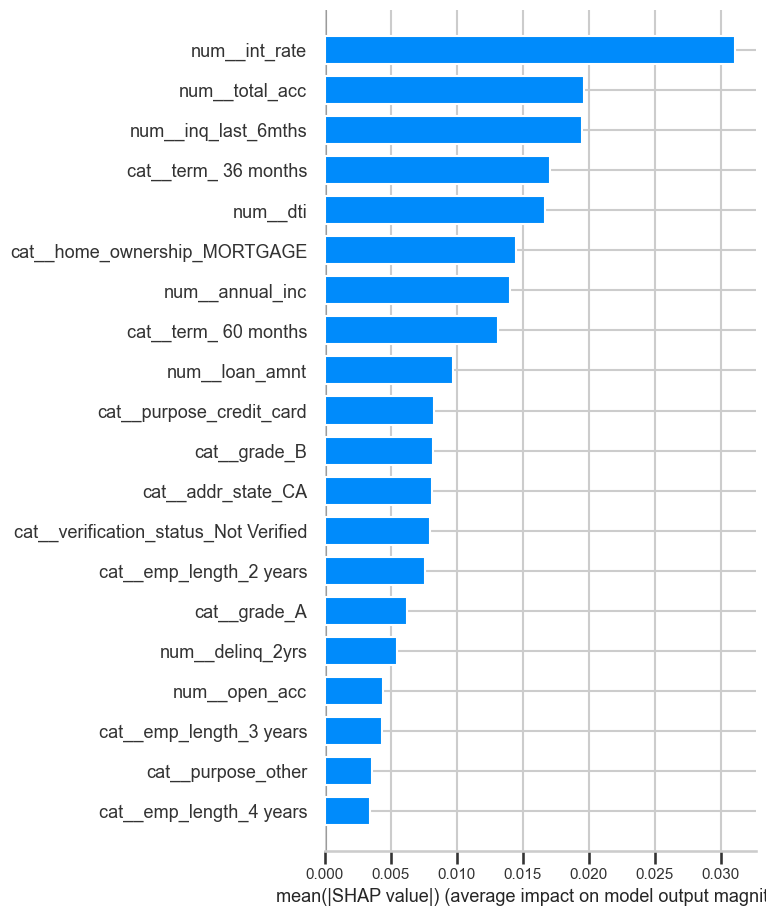

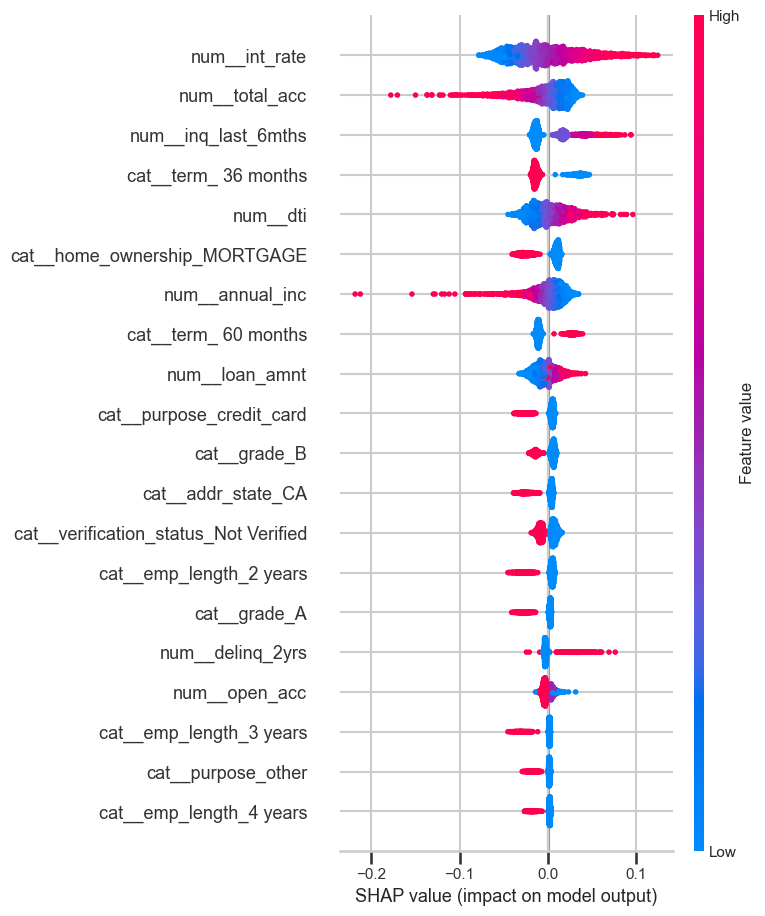


--- Figure 26: SHAP plot for Established-Credit ---
Using BERT for Established-Credit segment...


Batches:   0%|          | 0/6014 [00:00<?, ?it/s]

Batches:   0%|          | 0/1504 [00:00<?, ?it/s]

1504/1504 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step

✅ Final Evaluation for Established-Credit:
F1-Score: 0.4057
AUPRC:    0.3393


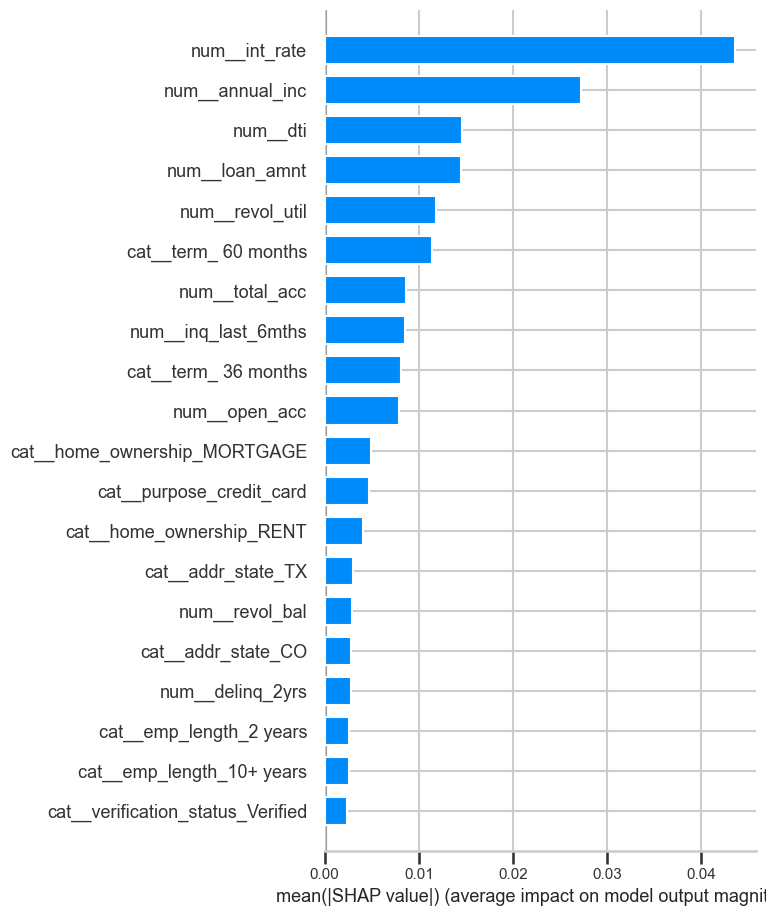

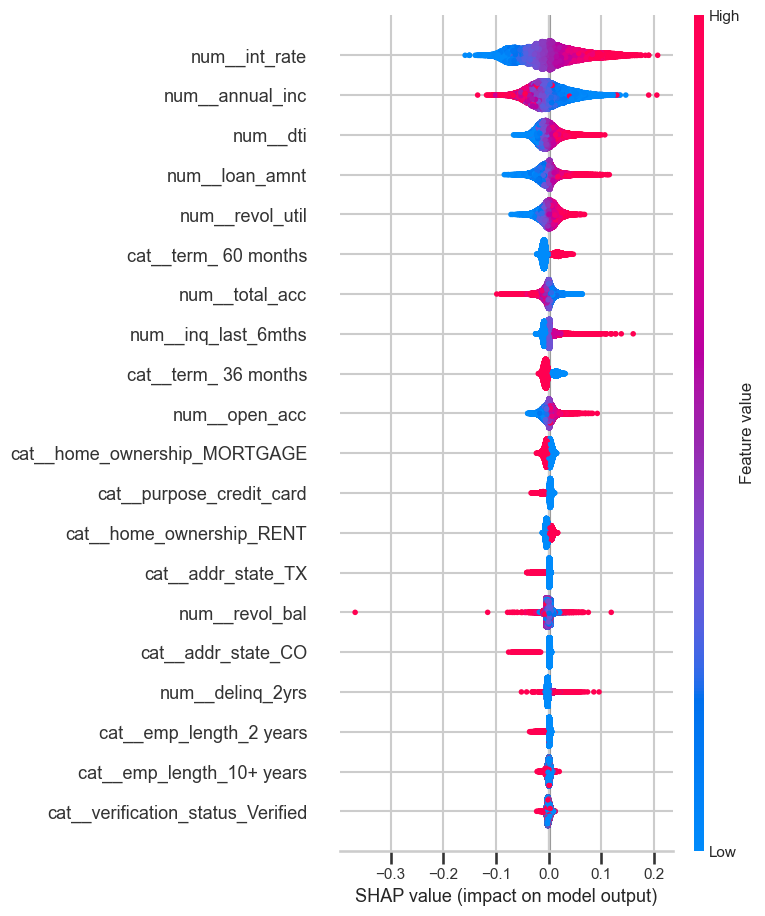


--- Cell 6: Champion Model Analysis complete ---


In [10]:
# =============================================================================
# Cell 6: Champion Model Analysis
# =============================================================================

sns.set_style("whitegrid")
sns.set_context("talk")

warnings.filterwarnings('ignore', message="The structure of `inputs` doesn't match the expected structure.")
warnings.filterwarnings('ignore', message="Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported.")

def run_shap_analysis_for_segment(
    segment_name,
    model_builder,
    nlp_type='bert',
    text_embedder=None
):
    if segment_name == 'Thin-File':
        X_train, y_train = X_train_thin, y_train_thin
        X_test, y_test = X_test_thin, y_test_thin
    elif segment_name == 'Established-Credit':
        X_train, y_train = X_train_est, y_train_est
        X_test, y_test = X_test_est, y_test_est
    else:
        raise ValueError("Invalid segment name")

    structured_numeric_features_local = X_train.select_dtypes(include=np.number).columns.tolist()
    structured_categorical_features_local = X_train.select_dtypes(include='object').drop('text_data', axis=1).columns.tolist()
    preprocessor_structured = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), structured_numeric_features_local),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), structured_categorical_features_local)
        ],
        remainder='drop'
    )
    preprocessor_structured.fit(X_train)
    X_train_struct = preprocessor_structured.transform(X_train)
    X_test_struct = preprocessor_structured.transform(X_test)
    structured_feature_names = preprocessor_structured.get_feature_names_out()
    if nlp_type == 'bert':
        print(f"Using BERT for {segment_name} segment...")
        if text_embedder is None:
            raise ValueError("text_embedder must be provided for BERT")
        X_train_text = text_embedder.encode(X_train['text_data'].tolist(), show_progress_bar=True, device='cpu')
        X_test_text = text_embedder.encode(X_test['text_data'].tolist(), show_progress_bar=True, device='cpu')
        text_feature_names = [f'bert_{i}' for i in range(X_train_text.shape[1])]

    elif nlp_type == 'tfidf':
        print(f"Using TF-IDF for {segment_name} segment...")
        tfidf_vectorizer = TfidfVectorizer(max_features=1000)
        X_train_text = tfidf_vectorizer.fit_transform(X_train['text_data']).toarray()
        X_test_text = tfidf_vectorizer.transform(X_test['text_data']).toarray()
        text_feature_names = tfidf_vectorizer.get_feature_names_out()
    else:
        raise ValueError(f"Unsupported nlp_type: {nlp_type}")

    X_train_fs = np.hstack([X_train_struct, X_train_text])
    X_test_fs = np.hstack([X_test_struct, X_test_text])
    all_feature_names = list(structured_feature_names) + list(text_feature_names)

    final_model = model_builder((X_train_fs.shape[1],))
    final_model.fit(
        X_train_fs, y_train,
        epochs=30, batch_size=256, verbose=0,
        validation_split=0.1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    y_probs = final_model.predict(X_test_fs).flatten()
    y_preds = (y_probs >= 0.2).astype(int)

    f1 = f1_score(y_test, y_preds)
    auprc = average_precision_score(y_test, y_probs)

    print(f"\n✅ Final Evaluation for {segment_name}:")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUPRC:    {auprc:.4f}")

    background_data = X_train_fs[np.random.choice(X_train_fs.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer((final_model.input, final_model.output), background_data)
    raw_shap_values = explainer.shap_values(X_test_fs)
    shap_values = raw_shap_values[0] if isinstance(raw_shap_values, list) else raw_shap_values
    if shap_values.ndim == 3 and shap_values.shape[2] == 1:
        shap_values = shap_values.squeeze(-1)

    shap.summary_plot(
        shap_values, features=X_test_fs, feature_names=all_feature_names,
        plot_type="bar", max_display=20, show=False
    )
    plt.tight_layout()
    plt.savefig(f'results/charts/shap_global_importance_{segment_name}.png')
    plt.show()

    shap.summary_plot(
        shap_values, features=X_test_fs, feature_names=all_feature_names,
        max_display=20, show=False
    )
    fig = plt.gcf()
    plt.tight_layout()
    fig.savefig(f'results/charts/shap_summary_{segment_name}.png')
    plt.show()

bert_model_global = SentenceTransformer('all-MiniLM-L6-v2')

print("\n--- Figure 23: SHAP plot for Thin-File ---")
run_shap_analysis_for_segment(
    segment_name='Thin-File',
    model_builder=build_mlp,
    nlp_type='tfidf'
)

print("\n--- Figure 24: SHAP plot for Established-Credit ---")
run_shap_analysis_for_segment(
    segment_name='Established-Credit',
    model_builder=build_mlp,
    nlp_type='bert',
    text_embedder=bert_model_global
)

print("\n--- Cell 6: Champion Model Analysis complete ---")